Import library and define function

In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
# viscosity = .01/pi

# Define initial condition
# def fun_u_0(x):
#     return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
# # parameter
# R0 = 0.95
# k0 = 2.2
# q0 = 1.1
# B0 = 0.5
# phib = 0.09
# c0 = B0/(R0**2*k0*q0)
# c1 = B0*(k0**2+1)/(R0**2*k0*q0)
# c2 = 0
a1 = 0.5
a2 = 0.5
def fun_r(r, z, lamda_i, phi_i, phi_r, phi_rr, phi_z, phi_zz):
    return -lamda_i*(a1+a2*r**2)*phi_i + phi_rr - phi_r/r + phi_zz

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



Generate collocation points

In [2]:
# Set number of data points
N_0 = 50
N_b = 200
N_r = 1000

# parameter
# R0 = 0.95
# k0 = 2.2
# q0 = 1.1
# B0 = 0.5
# phib = 0.09
# c0 = B0/(R0**2*k0*q0)
# c1 = B0*(k0**2+1)/(R0**2*k0*q0)
# c2 = 0

# Set boundary
# eps = 0.32
eps = 0.78
# kappa = 1.7
kappa = 2.0
# a = 0.336
a = np.arcsin(0.35)
print('d= ', np.sin(a))
phib = 0.0
t0 = tf.reshape(tf.linspace(0.0,2*pi,N_b), [N_b,1])
r_b = 1+eps*tf.cos(t0 + a*tf.sin(t0))
z_b = eps*kappa*tf.sin(t0)
# zmin = -1.
# zmax = 1.

# Lower bounds
rmin = min(r_b)
rmax = max(r_b)
lb = tf.constant(rmin, dtype=DTYPE)
# Upper bounds
ub = tf.constant(rmax, dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
# r_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
# z_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
# X_0 = tf.concat([r_0, z_0], axis=1)

# Evaluate intitial condition at x_0
# u_0 = fun_u_0(x_0)
# r_bound = tf.constant([rmin, rmax], dtype=DTYPE)
# z_bound = 1/r_bound*tf.sqrt(alpha**2 - k0**2/4*(r_bound**2-R0**2)**2)
# Boundary data
# r_b = tf.random.uniform((N_b,1), lb, ub, dtype=DTYPE)
# z_b = 1/r_b*tf.sqrt(alpha**2 - k0**2/4*(r_b**2-R0**2)**2)
X_b = tf.concat([r_b, z_b], axis=1)
# X_b_n = tf.concat([r_b, -z_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
phi_b = phib*tf.ones((len(z_b),1))
# phi_b_n = phib*tf.ones((len(z_b),1))


# Draw uniformly sampled collocation points
r_r = tf.random.uniform((N_r,1), lb, ub, dtype=DTYPE)
z_r = tf.convert_to_tensor(np.interp(r_r, r_b.numpy()[int(N_b/2):,0], z_b.numpy()[int(N_b/2):,0]), dtype=DTYPE)
z_r = z_r + tf.math.multiply(tf.random.uniform((len(r_r),1), 0, 1, dtype=DTYPE)*2,(-z_r))
X_r = tf.concat([r_r, z_r], axis=1)

# # Collect boundary and inital data in lists
X_data = [X_b]
phi_data = [phi_b]

d=  0.35


/var/folders/nn/94n61b9j0775vflz080y_3c00000gn/T/ipykernel_1879/1250455613.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(r_b, z_b, c='b', marker='X', vmin=-1, vmax=1)


Text(0.5, 1.0, 'Positions of collocation points and boundary data')

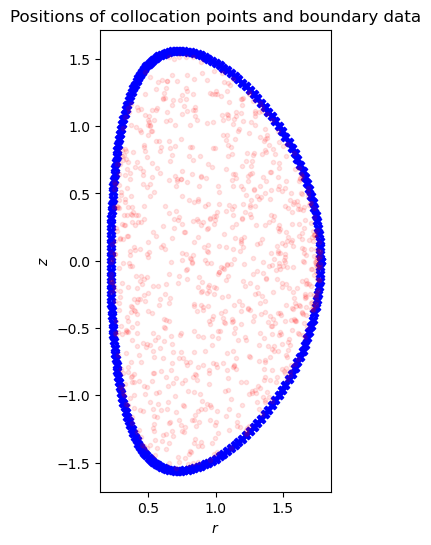

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
# plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(r_b, z_b, c='b', marker='X', vmin=-1, vmax=1)
# plt.scatter(r_b, -z_b, c=phi_b_n, marker='X', vmin=-1, vmax=1)
plt.scatter(r_r, z_r, c='r', marker='.', alpha=0.1)
# plt.scatter(r_bound, z_bound, marker='o')
plt.xlabel('$r$')
plt.ylabel('$z$')
plt.axis('scaled')
plt.title('Positions of collocation points and boundary data')

In [4]:
import random
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)
    # act_list = [tf.keras.activations.get('tanh'), tf.keras.activations.get('relu'), tf.keras.activations.get('mish'), tf.keras.activations.get('silu')]
    # Append hidden layers
    for _ in range(num_hidden_layers):
        # act_func = random.choice(act_list)
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('silu'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [5]:
def get_r(model, X_r, lamda_i, phi_i):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        r, z = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(r)
        tape.watch(z)

        # Determine residual 
        phi = model(tf.stack([r[:,0], z[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        phi_r = tape.gradient(phi, r)
        phi_z = tape.gradient(phi, z)
            
    # u_t = tape.gradient(u, t)
    phi_rr = tape.gradient(phi_r, r)
    phi_zz = tape.gradient(phi_z, z)

    del tape

    return fun_r(r, z, lamda_i, phi_i, phi_r, phi_rr, phi_z, phi_zz)

In [6]:
def compute_loss(model, X_r, X_data, phi_data, lamda_i, phi_i):
    
    # Compute phi^r
    r = get_r(model, X_r, lamda_i, phi_i)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        phi_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(phi_data[i] - phi_pred))
    
    return loss

In [7]:
def get_grad(model, X_r, X_data, phi_data, lamda_i, phi_i):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, phi_data, lamda_i, phi_i)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [8]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

In [9]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(lamda_i, phi_i):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, phi_data, lamda_i, phi_i)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

def infty_norm(x):
    return np.max(np.abs(x))

# Number of training epochs
N = 5000

lamda0 = 10.0
base_model = tf.keras.models.load_model('saved_model/homogen_boundary')
phi0 = base_model(X_r)
arr_lamda = [lamda0]
arr_phi = [phi0]

# Start timer
for j in range(10):
    t0 = time()
    hist = []
    for i in range(N+1):
        
        loss = train_step(arr_lamda[-1], arr_phi[-1])
        
        # Append current loss to hist
        hist.append(loss.numpy())
        
        # Output current loss after 50 iterates
        if i%50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        if i > 100:
            if (np.abs(np.diff(np.array(hist)))[-100:] < 1e-5).all():
                print('stop iteration for j=',j,' is ',i)
                break
    if loss < 5e-2:
        phi_est = model(X_r)
        norm_phi = infty_norm(phi_est)
        arr_phi.append(phi_est/norm_phi)
        arr_lamda.append(arr_lamda[-1]/norm_phi)
        arr_lamda[-1] = arr_lamda[-1].astype('float32')
        print('lamda-', j,': ', arr_lamda[-1])
        print('norm phi: ', norm_phi)
    else:
        print('failed')
        break
            
    # Print computation time
    print('\nComputation time: {} seconds'.format(time()-t0))

2023-06-20 11:20:58.065711: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


It 00000: loss = 2.17287612e+00
It 00050: loss = 5.88441826e-02
It 00100: loss = 4.11774265e-03
It 00150: loss = 4.78687976e-03
It 00200: loss = 3.67966527e-03
It 00250: loss = 6.85319724e-03
It 00300: loss = 2.95895734e-03
It 00350: loss = 2.22704210e-03
It 00400: loss = 2.72275647e-03
It 00450: loss = 4.33060480e-03
It 00500: loss = 6.19676057e-03
It 00550: loss = 4.47786832e-03
It 00600: loss = 8.28833377e-04
It 00650: loss = 2.51169666e-03
It 00700: loss = 1.57783472e-03
It 00750: loss = 4.93778335e-03
It 00800: loss = 1.06328400e-03
It 00850: loss = 4.37530223e-04
It 00900: loss = 1.28230313e-03
It 00950: loss = 4.97036090e-04
It 01000: loss = 5.34333754e-04
It 01050: loss = 1.23924765e-04
It 01100: loss = 1.14626157e-04
stop iteration for j= 0  is  1132
lamda- 0 :  25.392666
norm phi:  0.3938145

Computation time: 95.24417400360107 seconds
It 00000: loss = 2.39733734e+02
It 00050: loss = 2.02970085e+01
It 00100: loss = 1.14944971e+00
It 00150: loss = 1.45767167e-01
It 00200: loss

Text(0.5, 0.92, 'Solution of GS equation')

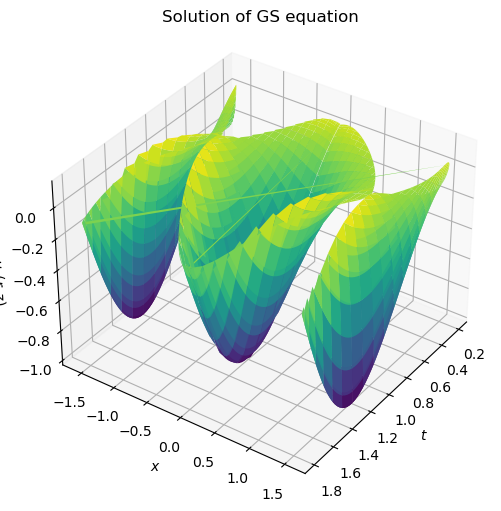

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = int(N_b/2)
rspace = r_b[int(N_b/2):,0]
zspace = z_b[int(N_b/2):,0]
R, Z = np.meshgrid(rspace, zspace)
Xgrid = np.vstack([R.flatten(),Z.flatten()]).T
Xgrid = np.concatenate((Xgrid, np.vstack([R.flatten(),-Z.flatten()]).T), axis=0)
ineq = np.abs(Xgrid[:,1]) < -np.array([zspace[rspace == Xgrid[i,0]][0] for i in range(len(Xgrid))])
# Xgrid = Xgrid[ineq]

# Determine predictions of u(t, x)
phipred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
phi = phipred.numpy().reshape(N,2*N)
ineq = ineq.reshape(N,2*N)
R_ax = Xgrid[:,0].reshape(N,2*N)
Z_ax = Xgrid[:,1].reshape(N,2*N)
phi[~ineq] = np.nan

total_R = np.concatenate((R,R),axis=1)
total_Z = np.concatenate((Z, -Z),axis=1)

# # Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(total_R, total_Z, phi, cmap='viridis')
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\phi(r,z)$')
ax.set_title('Solution of GS equation')
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

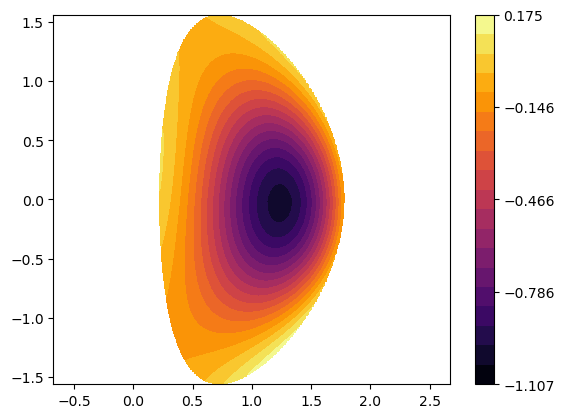

In [11]:
min_phi = np.nanmin(phi.flatten())
max_phi = np.nanmax(phi.flatten())
levels1 = np.linspace(min_phi - abs(min_phi)*0.1, max_phi + abs(max_phi)*0.2,20)
level_ticks = np.linspace(min_phi - abs(min_phi)*0.1, max_phi + abs(max_phi)*0.2,5)
fig = plt.contourf(R_ax, Z_ax, phi, levels1, cmap='inferno')
plt.axis('equal')
plt.colorbar(fig, ticks=level_ticks)

/var/folders/nn/94n61b9j0775vflz080y_3c00000gn/T/ipykernel_1879/2953584796.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(r_b, z_b, c='b', marker='X', vmin=-1, vmax=1)


(0.14204215109348295,
 1.8579979628324508,
 -1.7159464359283447,
 1.7159464359283447)

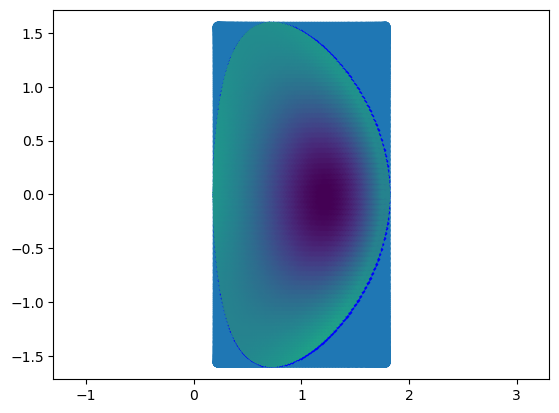

In [12]:
plt.scatter(total_R,total_Z)
plt.scatter(r_b, z_b, c='b', marker='X', vmin=-1, vmax=1)
# plt.scatter(r_b, -z_b, c='b', marker='X', vmin=-1, vmax=1)
plt.scatter(R_ax, Z_ax, c=phi, marker='X', vmin=-1, vmax=1)

plt.axis('equal')

Text(0, 0.5, '$\\phi_{n_{epoch}}$')

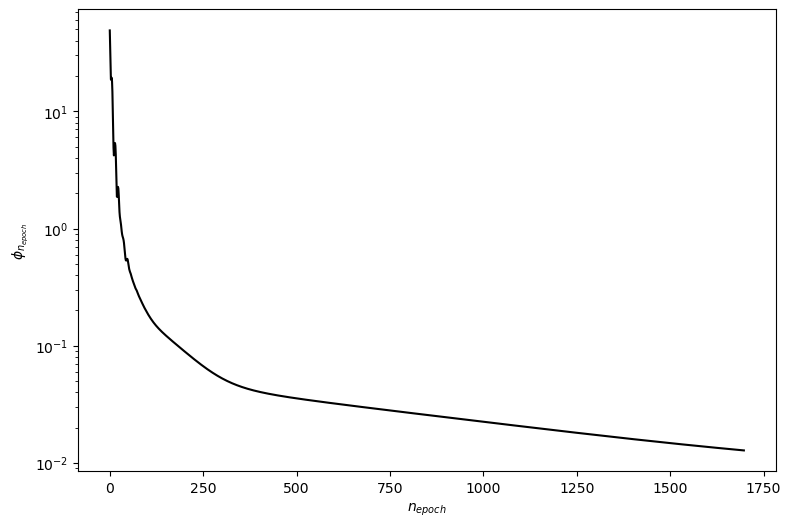

In [13]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')

Loss per point

In [14]:
def compute_loss_inner(model, X_r,lamda_i, y_i):
    
    # Compute phi^r
    r = get_r(model, X_r,lamda_i, y_i)
    phi_r = tf.square(r)
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    # for i in range(len(X_data)):
    #     phi_pred = model(X_data[i])
    #     loss += tf.reduce_mean(tf.square(phi_data[i] - phi_pred))
    
    return loss.numpy()

def compute_loss_data(model, X_data, phi_data):
    
    # Compute phi^r
    # r = get_r(model, X_r)
    # phi_r = tf.square(r)
    
    # Initialize loss
    loss = []
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(phi_data)):
        phi_pred = model(X_data[i])
        loss.append(tf.square(phi_data[i] - phi_pred).numpy())
        # print(tf.square(phi_data[i] - phi_pred).numpy())
    return loss

In [15]:
err = compute_loss_inner(model, tf.convert_to_tensor(Xgrid),arr_lamda[-1], arr_phi[-1]) #adjust arr_phi[-1] to Xgrid
err = err.reshape(N, 2*N)
err[~ineq] = np.nan
plt.contourf(R_ax, Z_ax, err)
plt.axis('equal')
plt.colorbar()

InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Incompatible shapes: [20000,1] vs. [1000,1] [Op:Mul]

In [ ]:
compute_loss_data(model, X_data, phi_data)

[array([[6.12022788e-08],
        [7.21194198e-08],
        [8.57113349e-08],
        [1.02469521e-07],
        [1.22912596e-07],
        [1.48198751e-07],
        [1.79346202e-07],
        [2.17244818e-07],
        [2.63593847e-07],
        [3.19833447e-07],
        [3.88218183e-07],
        [4.71157250e-07],
        [5.71746114e-07],
        [6.93763411e-07],
        [8.42168390e-07],
        [1.02379579e-06],
        [1.24672465e-06],
        [1.52122232e-06],
        [1.86094860e-06],
        [2.28166368e-06],
        [2.80351765e-06],
        [3.44720183e-06],
        [4.23714800e-06],
        [5.19567675e-06],
        [6.34328899e-06],
        [7.69260714e-06],
        [9.24592041e-06],
        [1.09926332e-05],
        [1.29054170e-05],
        [1.49416655e-05],
        [1.70442272e-05],
        [1.91537438e-05],
        [2.12096020e-05],
        [2.31593276e-05],
        [2.49700279e-05],
        [2.66300030e-05],
        [2.81443063e-05],
        [2.95365444e-05],
        [3.0

In [ ]:
def nabla_phi(model, X_r):
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        r, z = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(r)
        tape.watch(z)

        # Determine residual 
        phi = model(tf.stack([r[:,0], z[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
    phi_r = tape.gradient(phi, r)
    phi_z = tape.gradient(phi, z)

    del tape
    return np.concatenate([phi_r.numpy(), np.zeros((len(X_r),1)), phi_z.numpy()],axis=1)
    

In [ ]:
a = np.cross(nabla_phi(model, X_r)/X_r[:,0:1].numpy(),np.array([0,1,0]))